## Neural Network Model to Predict Hospital Admission Costs


In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

In [3]:
#import preprocessed data (preprocessing & saving done in the other notebook)
df = pd.read_csv('preprocessed_data/data_preprocessed.csv')
df.head()

,patient_id,date_of_birth,gender,race,resident_status,weight,height,BMI_value,BMI_class,age_on_admission,date_of_admission,date_of_discharge,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,freq
0,62bdca0b95d97e99e1c712048fb9fd09,1978-07-20,f,Malay,Singaporean,78.4,160.0,30.625000,obese,32,2011-01-01,2011-01-11,10,1,23303.000924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,13.8,22.6,89.0,0
1,1d21f2be18683991eb93d182d6b2d220,1976-12-19,m,Indian,Singaporean,71.3,161.0,27.506655,obese,34,2011-01-01,2011-01-11,10,2,15405.418665,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,13.2,30.9,123.0,0
2,79f52395dab0e6d3a03c48f765cb6562,1936-04-05,m,Chinese,Singaporean,92.8,176.0,29.958678,obese,74,2011-01-02,2011-01-18,16,1,17153.905421,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,12.1,23.6,109.0,0
3,e0397dd72caf4552c5babebd3d61736c,1967-12-06,f,Chinese,Singaporean,64.4,152.0,27.873961,obese,43,2011-01-02,2011-01-14,12,1,27994.878530,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,13.3,28.4,76.0,0
4,c85cf97bc6307ded0dd4fef8bad2fa09,1967-08-14,f,Indian,Singaporean,72.0,151.0,31.577562,obese,43,2011-01-02,2011-01-13,11,2,16813.123088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,11.2,26.2,100.0,0


In [4]:
#choose features 
data = df[['gender', 'race', 'resident_status', 'BMI_value', 'age_on_admission', 'length_of_stay', 'total_admissions', 'amount', 'medical_history_1', 'medical_history_6', 'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'freq']]

In [5]:
data = pd.get_dummies(data, drop_first = True)
data.head()

,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,freq,gender_m,race_Indian,race_Malay,race_Other,resident_status_Singaporean
0,30.625000,32,10,1,23303.000924,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0,1,0,1
1,27.506655,34,10,2,15405.418665,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,1,1,0,0,1
2,29.958678,74,16,1,17153.905421,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,1,0,0,0,1
3,27.873961,43,12,1,27994.878530,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,1
4,31.577562,43,11,2,16813.123088,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0,0,1,0,0,1


### Train, test and validation data

In [6]:
#train data (90% of the data) and test data (10% of the data)
x = data.drop('amount', axis = 1)
y = data['amount']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 25, shuffle = True)

#let's further separate validation data set (10 % from the train data): 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 25, shuffle = True)

#scale
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

print(f"training examples: {x_train.shape[0]}")
print(f"testing examples: {x_test.shape[0]}")
print(f'validation examples: {x_val.shape[0]}')

training examples: 2347
testing examples: 290
validation examples: 261


In [7]:
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

(2347, 17) (261, 17) (290, 17) (2347,) (261,) (290,)


### Neural Network Model

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model=keras.models.Sequential([
    keras.layers.Dense(100, input_dim = x_train.shape[1], activation='relu'),  
    keras.layers.Dense(200, input_dim = x_train.shape[1], activation='relu'),  
    keras.layers.Dense(1, activation='linear'),  
])
    
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), tf.keras.metrics.MeanAbsoluteError(name='mae')]) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1800      
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 22,201
Trainable params: 22,201
Non-trainable params: 0
_________________________________________________________________


2022-02-07 01:08:29.259100: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
history = model.fit(x_train, y_train,
                    epochs=1000, batch_size=500,
                    validation_data=(x_test, y_test), 
                    verbose=1, shuffle = True, validation_split = 0.2)

### Evaluating the Model

In [10]:
model.evaluate(x_test, y_test)

10/10 [==============================] - 0s 1ms/step - loss: 4517020.0000 - rmse: 2125.3281 - mae: 1602.2076


[4517020.0, 2125.328125, 1602.2076416015625]

Train RMSE: 2124.847900390625
Train MAE: 1477.088623046875
Test RMSE: 2125.328125
Test MAE: 1602.2076416015625


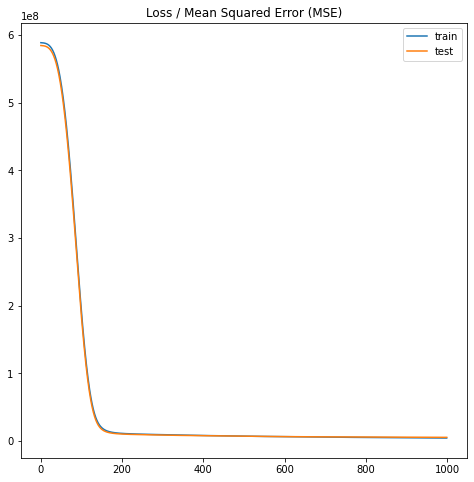

In [11]:
# evaluate the model
plt.figure(figsize=(8, 8))
metrics_train = model.evaluate(x_train, y_train, verbose=0)
metrics_test = model.evaluate(x_test, y_test, verbose=0)
print('Train RMSE:', metrics_train[1])
print('Train MAE:', metrics_train[2])
print('Test RMSE:', metrics_test[1])
print('Test MAE:', metrics_test[2])


# plot loss during training
plt.title('Loss / Mean Squared Error (MSE)')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.plot()
plt.legend()
plt.show()

In [12]:
#validation metrics
metrics_val = model.evaluate(x_val, y_val, verbose=0)
print('Validation RMSE:', metrics_val[1])
print('Validation MAE:', metrics_val[2])

Validation RMSE: 2637.36572265625
Validation MAE: 1902.306640625


In [13]:
#sets monetary values to plot axis 
def monetary_ticks(value, tick_number):
    return f'{value/1000:,.0f}'+'k'

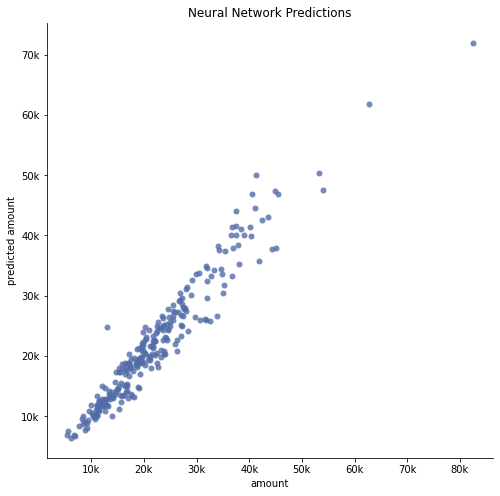

In [14]:
#predictions 
y_pred = model.predict(x_val).flatten()

plt.figure(figsize=(8, 8))
g = sns.scatterplot(x=y_val, y=y_pred, color = '#526ca9', alpha = 0.8, linewidth=0)
g.set_title('Neural Network Predictions')
g.set_xlabel('amount')
g.set_ylabel('predicted amount')

g.xaxis.set_major_formatter(FuncFormatter(monetary_ticks))
g.yaxis.set_major_formatter(FuncFormatter(monetary_ticks))


sns.despine()
plt.show() 